In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [172]:
params = []
prefix = '../../../..'

paths = sorted(glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-19*/**/rep00/", recursive=True) 
                   + glob.glob(f"{prefix}/logs/lions-maxtwo*-2019-06-15*/**/rep00/", recursive=True)
                  + glob.glob(f"{prefix}/logs/lions-maxtwo*-2019-06-14*/**/rep00/", recursive=True)
                   + glob.glob(f"{prefix}/logs/lions-maxtwo*-2019-06-13*/**/rep00/", recursive=True)
                  + glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-20*/**/rep00/", recursive=True)
                  + glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-21*/**/rep00/", recursive=True)
                   + glob.glob(f"{prefix}/logs/lions-maxtwo**-2019-06-22*/**/rep00/", recursive=True)
                  )
paths = sorted(glob.glob(f"{prefix}/logs/lions-nvar-*-2019-06-*/**/rep00/", recursive=True))
for path in paths:
    print(path)
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    print('*-*-*')
    params.append((path, readparams(glob.glob(path + 'properties*')[0]), logall.query('nbOnOpp == 2')['curCoopNoCoef'].mean()))



../../../../logs/lions-nvar-pop1000-lowmut-lotofreps-fake_true-0.5-b10-nocost-additive-decay-1000-2019-06-24-1043/lion_megabig/o100/mt_false/run_01/rep00/
*-*-*
../../../../logs/lions-nvar-pop1000-lowmut-lotofreps-fake_true-0.5-b10-nocost-additive-decay-1000-2019-06-24-1043/lion_megabig/o100/mt_false/run_02/rep00/
*-*-*
../../../../logs/lions-nvar-pop1000-lowmut-lotofreps-fake_true-0.5-b10-nocost-additive-decay-1000-2019-06-24-1043/lion_megabig/o1001/mt_false/run_01/rep00/
*-*-*
../../../../logs/lions-nvar-pop1000-lowmut-lotofreps-fake_true-0.5-b10-nocost-additive-decay-1000-2019-06-24-1043/lion_megabig/o1001/mt_false/run_02/rep00/
*-*-*
../../../../logs/lions-nvar-pop1000-lowmut-lotofreps-fake_true-0.5-b10-nocost-additive-decay-1000-2019-06-24-1043/lion_megabig/o20/mt_false/run_01/rep00/
*-*-*
../../../../logs/lions-nvar-pop1000-lowmut-lotofreps-fake_true-0.5-b10-nocost-additive-decay-1000-2019-06-24-1043/lion_megabig/o20/mt_false/run_02/rep00/
*-*-*
../../../../logs/lions-nvar-pop100

In [173]:
diffkeys = set()
missingkeys = set()
for i in range(len(params)):
    for key in params[i][1].keys():
        try:
            if any(params[j][1][key] != params[i][1][key] for j in range(0, len(params) - 1)):
                diffkeys.add(key)
        except KeyError:
            missingkeys.add(key)

In [174]:
excluded = ['gSeed', 'gLogFilename', 'path']
processed = []
for elem in params:
    param = elem[1]
    ess = param['meanA'] / 2
    so = param['meanA'] + param['b'] / 2
    outdict = {'coop': (elem[2] - ess) / (so - ess) , 'truecoop': elem[2]}
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem[1][key]
    processed.append(outdict)
    for key in missingkeys:
        if key in excluded: continue
        outdict[key] = elem[1].get(key, False)
df = pd.DataFrame(processed)
normalized_df=(df-df.mean())/df.std()

In [177]:
df

,coop,gNbOfPhysicalObjects,gRandomSeed,truecoop
0,0.031440,100.0,-849859442.0,2.735801
1,0.093465,100.0,-849858189.0,3.200991
2,0.578437,1001.0,-839987968.0,6.838281
3,0.462336,1001.0,-839988108.0,5.967521
4,-0.048876,20.0,-850061013.0,2.133428
5,-0.002350,20.0,-850060998.0,2.482373
6,-0.046499,400.0,-839715108.0,2.151255
7,-0.018599,400.0,-839714667.0,2.360505
8,0.483211,600.0,-839829251.0,6.124079
9,0.551116,600.0,-839827969.0,6.633371


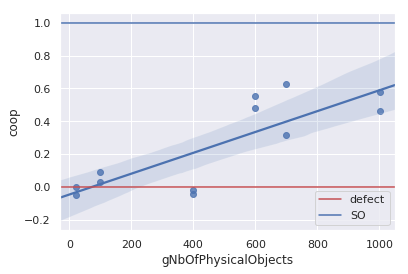

In [178]:
sns.regplot(x='gNbOfPhysicalObjects', y='coop', data=df)
plt.axhline(0, label='defect', c='r')
plt.axhline(1, label='SO', c='b')
plt.legend()

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
normalized_df['nbRobots'] = normalized_df['gInitialNumberOfRobots']
normalized_df['tau'] = normalized_df['oppDecay']
normalized_df['coopVariability'] = normalized_df['fakeCoef']
normalized_df

In [ ]:
result = sm.ols(formula="coop ~ nbRobots + b + tau + coopVariability + additiveVar", data=normalized_df).fit()

In [ ]:
result.summary()

In [180]:
df

,coop,gNbOfPhysicalObjects,gRandomSeed,truecoop
0,0.031440,100.0,-849859442.0,2.735801
1,0.093465,100.0,-849858189.0,3.200991
2,0.578437,1001.0,-839987968.0,6.838281
3,0.462336,1001.0,-839988108.0,5.967521
4,-0.048876,20.0,-850061013.0,2.133428
5,-0.002350,20.0,-850060998.0,2.482373
6,-0.046499,400.0,-839715108.0,2.151255
7,-0.018599,400.0,-839714667.0,2.360505
8,0.483211,600.0,-839829251.0,6.124079
9,0.551116,600.0,-839827969.0,6.633371
